In [259]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Generate dataset

In [260]:
y = np.random.randint(0,10,5000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)

0 493
1 507
2 495
3 548
4 515
5 511
6 483
7 492
8 495
9 461


In [0]:
x = np.zeros((5000,2))

In [0]:
# x[idx[0],:] = np.random.multivariate_normal(mean = [5,5],cov=[[0.1,0],[0,0.1]],size=sum(idx[0]))

# x[idx[1],:] = np.random.multivariate_normal(mean = [-6,7],cov=[[0.1,0],[0,0.1]],size=sum(idx[1]))

# x[idx[2],:] = np.random.multivariate_normal(mean = [-5,-4],cov=[[0.1,0],[0,0.1]],size=sum(idx[2]))

x[idx[0],:] = np.random.multivariate_normal(mean = [5,5],cov=[[0.1,0],[0,0.1]],size=sum(idx[0]))

x[idx[1],:] = np.random.multivariate_normal(mean = [6,6],cov=[[0.1,0],[0,0.1]],size=sum(idx[1]))

x[idx[2],:] = np.random.multivariate_normal(mean = [5.5,6.5],cov=[[0.1,0],[0,0.1]],size=sum(idx[2]))

x[idx[3],:] = np.random.multivariate_normal(mean = [-1,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[3]))


x[idx[4],:] = np.random.multivariate_normal(mean = [0,2],cov=[[0.1,0],[0,0.1]],size=sum(idx[4]))

x[idx[5],:] = np.random.multivariate_normal(mean = [1,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[5]))

x[idx[6],:] = np.random.multivariate_normal(mean = [0,-1],cov=[[0.1,0],[0,0.1]],size=sum(idx[6]))

x[idx[7],:] = np.random.multivariate_normal(mean = [0,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[7]))

x[idx[8],:] = np.random.multivariate_normal(mean = [-0.5,-0.5],cov=[[0.1,0],[0,0.1]],size=sum(idx[8]))

x[idx[9],:] = np.random.multivariate_normal(mean = [0.4,0.2],cov=[[0.1,0],[0,0.1]],size=sum(idx[9]))

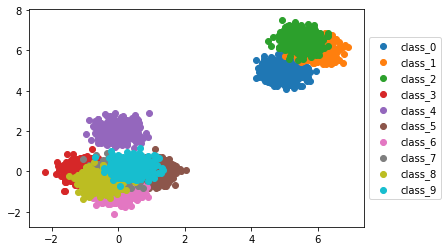

In [263]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [0]:
foreground_classes = {'class_0','class_1', 'class_2'}

background_classes = {'class_3','class_4', 'class_5', 'class_6','class_7', 'class_8', 'class_9'}

In [265]:
fg_class  = np.random.randint(0,3)
fg_idx = np.random.randint(0,9)

a = []
for i in range(9):
    if i == fg_idx:
        b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
        a.append(x[b])
        print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
        bg_class = np.random.randint(3,10)
        b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
        a.append(x[b])
        print("background "+str(bg_class)+" present at " + str(i))
a = np.concatenate(a,axis=0)
print(a.shape)

print(fg_class , fg_idx)

background 5 present at 0
background 9 present at 1
background 4 present at 2
foreground 1 present at 3
background 5 present at 4
background 5 present at 5
background 6 present at 6
background 9 present at 7
background 6 present at 8
(9, 2)
1 3


In [266]:
a.shape

(9, 2)

In [267]:
np.reshape(a,(18,1))

array([[ 0.22974466],
       [-0.39040645],
       [ 0.94520827],
       [ 0.24263521],
       [ 0.441134  ],
       [ 2.15395791],
       [ 6.50413651],
       [ 6.45043273],
       [ 1.06526469],
       [ 0.0639449 ],
       [ 0.29200388],
       [-0.36412841],
       [-0.26132779],
       [-0.65306613],
       [ 0.46086385],
       [ 0.13727236],
       [-0.34798446],
       [-0.76142478]])

In [0]:
a=np.reshape(a,(3,6))

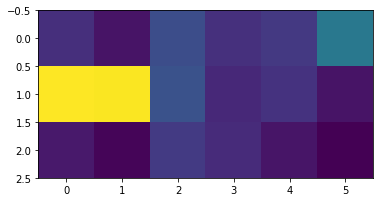

In [269]:
plt.imshow(a)

In [0]:
desired_num = 3000
mosaic_list =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,9)
    a = []
    for i in range(9):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,10)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list.append(np.reshape(a,(18,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [0]:
mosaic_list = np.concatenate(mosaic_list,axis=1).T
# print(mosaic_list)

In [272]:
print(np.shape(mosaic_label))
print(np.shape(fore_idx))

(3000,)
(3000,)


In [0]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [0]:
class Wherenet(nn.Module):
    def __init__(self):
        super(Wherenet,self).__init__()
        self.linear1 = nn.Linear(2,4)
        self.linear2 = nn.Linear(4,8)
        self.linear3 = nn.Linear(8,1)
    def forward(self,z):
        x = torch.zeros([batch,9],dtype=torch.float64)
        y = torch.zeros([batch,2], dtype=torch.float64)
        #x,y = x.to("cuda"),y.to("cuda")
        for i in range(9):
            x[:,i] = self.helper(z[:,2*i:2*i+2])[:,0]
            #print(k[:,0].shape,x[:,i].shape)
        x = F.softmax(x,dim=1)   # alphas
        x1 = x[:,0]
        for i in range(9):
            x1 = x[:,i]          
            #print()
            y = y+torch.mul(x1[:,None],z[:,2*i:2*i+2])
        return y , x 

    
    def helper(self,x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

    

In [0]:
trainiter = iter(train_loader)
input1,labels1,index1 = trainiter.next()



In [276]:
where = Wherenet().double()
where = where
out_where,alphas = where(input1)
out_where.shape,alphas.shape

(torch.Size([250, 2]), torch.Size([250, 9]))

In [0]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(2,4)
        self.linear2 = nn.Linear(4,3)
#         self.linear3 = nn.Linear(8,3)
    def forward(self,x):
        x = F.relu(self.linear1(x))
        #x = F.relu(self.linear2(x))
        x = self.linear2(x)
        return x

In [0]:
what = Whatnet().double()
# what(out_where)

In [0]:
test_data_required = 1000
mosaic_list_test =[]
mosaic_label_test = []
fore_idx_test=[]
for j in range(test_data_required):
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,9)
    a = []
    for i in range(9):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,10)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_test.append(np.reshape(a,(18,1)))
    mosaic_label_test.append(fg_class)
    fore_idx_test.append(fg_idx)

In [280]:
mosaic_list_test = np.concatenate(mosaic_list_test,axis=1).T
print(mosaic_list_test.shape)

(1000, 18)


In [0]:
test_data = MosaicDataset(mosaic_list_test,mosaic_label_test,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [282]:

focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

criterion = nn.CrossEntropyLoss()
optimizer_where = optim.SGD(where.parameters(), lr=0.01, momentum=0.9)
optimizer_what = optim.SGD(what.parameters(), lr=0.01, momentum=0.9)

nos_epochs = 120

train_loss=[]
test_loss =[]
train_acc = []
test_acc = []
for epoch in range(nos_epochs):  # loop over the dataset multiple times

    focus_true_pred_true =0
    focus_false_pred_true =0
    focus_true_pred_false =0
    focus_false_pred_false =0

    argmax_more_than_half = 0
    argmax_less_than_half =0

    running_loss = 0.0
    cnt=0

    iteration = desired_num // batch

    #training data set

    for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        #inputs,labels,fore_idx = inputs.to(device),labels.to(device),fore_idx.to(device)
        # zero the parameter gradients

        optimizer_what.zero_grad()
        optimizer_where.zero_grad()
        
        
        avg_inp,alphas = where(inputs)
        
        outputs = what(avg_inp)
        
        _, predicted = torch.max(outputs.data, 1)
        
        loss = criterion(outputs, labels) 
        loss.backward() 
        
        optimizer_what.step()
        optimizer_where.step() 
        

        running_loss += loss.item()
        if cnt % 6 == 5:    # print every 6 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / 6))
            running_loss = 0.0
        cnt=cnt+1
    
        if epoch % 5 == 4:
            for j in range (batch):
                focus = torch.argmax(alphas[j])

                if(alphas[j][focus] >= 0.5):
                    argmax_more_than_half +=1
                else:
                    argmax_less_than_half +=1

                if(focus == fore_idx[j] and predicted[j] == labels[j]):
                    focus_true_pred_true += 1

                elif(focus != fore_idx[j] and predicted[j] == labels[j]):
                    focus_false_pred_true +=1

                elif(focus == fore_idx[j] and predicted[j] != labels[j]):
                    focus_true_pred_false +=1

                elif(focus != fore_idx[j] and predicted[j] != labels[j]):
                    focus_false_pred_false +=1

    if epoch % 5 == 4:
        col1.append(epoch)
        col2.append(argmax_more_than_half)
        col3.append(argmax_less_than_half)
        col4.append(focus_true_pred_true)
        col5.append(focus_false_pred_true)
        col6.append(focus_true_pred_false)
        col7.append(focus_false_pred_false)

    #************************************************************************
        #testing data set  
        with torch.no_grad():
            focus_true_pred_true =0
            focus_false_pred_true =0
            focus_true_pred_false =0
            focus_false_pred_false =0

            argmax_more_than_half = 0
            argmax_less_than_half =0
            for data in test_loader:
                inputs, labels , fore_idx = data
                #inputs,labels,fore_idx = inputs.to(device),labels.to(device),fore_idx.to(device) 
#                 print(inputs.shtorch.save(where.state_dict(),"model_epoch"+str(epoch)+".pt")ape,labels.shape)
                avg_inp,alphas = where(inputs)
                outputs = what(avg_inp)
                _, predicted = torch.max(outputs.data, 1)

                for j in range (batch):
                    focus = torch.argmax(alphas[j])

                    if(alphas[j][focus] >= 0.5):
                        argmax_more_than_half +=1
                    else:
                        argmax_less_than_half +=1

                    if(focus == fore_idx[j] and predicted[j] == labels[j]):
                        focus_true_pred_true += 1

                    elif(focus != fore_idx[j] and predicted[j] == labels[j]):
                        focus_false_pred_true +=1

                    elif(focus == fore_idx[j] and predicted[j] != labels[j]):
                        focus_true_pred_false +=1

                    elif(focus != fore_idx[j] and predicted[j] != labels[j]):
                        focus_false_pred_false +=1

        col8.append(argmax_more_than_half)
        col9.append(argmax_less_than_half)
        col10.append(focus_true_pred_true)
        col11.append(focus_false_pred_true)
        col12.append(focus_true_pred_false)
        col13.append(focus_false_pred_false)
        torch.save(where.state_dict(),"where_model_epoch"+str(epoch)+".pt")
        torch.save(what.state_dict(),"what_model_epoch"+str(epoch)+".pt")
    
print('Finished Training')
torch.save(where.state_dict(),"where_model_epoch"+str(nos_epochs)+".pt")
torch.save(what.state_dict(),"what_model_epoch"+str(epoch)+".pt")


[1,     6] loss: 1.111
[1,    12] loss: 1.097
[2,     6] loss: 1.088
[2,    12] loss: 1.093
[3,     6] loss: 1.082
[3,    12] loss: 1.073
[4,     6] loss: 1.063
[4,    12] loss: 1.057
[5,     6] loss: 1.043
[5,    12] loss: 1.031
[6,     6] loss: 1.015
[6,    12] loss: 1.005
[7,     6] loss: 0.989
[7,    12] loss: 0.972
[8,     6] loss: 0.956
[8,    12] loss: 0.941
[9,     6] loss: 0.919
[9,    12] loss: 0.909
[10,     6] loss: 0.883
[10,    12] loss: 0.873
[11,     6] loss: 0.841
[11,    12] loss: 0.836
[12,     6] loss: 0.804
[12,    12] loss: 0.794
[13,     6] loss: 0.769
[13,    12] loss: 0.756
[14,     6] loss: 0.734
[14,    12] loss: 0.729
[15,     6] loss: 0.714
[15,    12] loss: 0.684
[16,     6] loss: 0.682
[16,    12] loss: 0.659
[17,     6] loss: 0.656
[17,    12] loss: 0.629
[18,     6] loss: 0.617
[18,    12] loss: 0.612
[19,     6] loss: 0.598
[19,    12] loss: 0.574
[20,     6] loss: 0.579
[20,    12] loss: 0.557
[21,     6] loss: 0.557
[21,    12] loss: 0.531
[22,     6

In [0]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [284]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,4,0,3000,1073,0,1927,0
1,9,1179,1821,1957,10,1033,0
2,14,990,2010,2041,227,677,55
3,19,1021,1979,2403,76,516,5
4,24,1416,1584,2375,21,604,0
5,29,1509,1491,2568,17,415,0
6,34,2070,930,2521,11,468,0
7,39,2330,670,2584,1,415,0
8,44,2675,325,2572,0,428,0
9,49,2292,708,2641,0,359,0


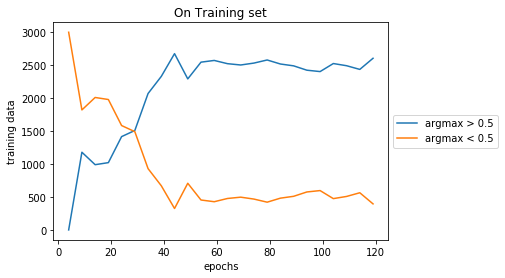

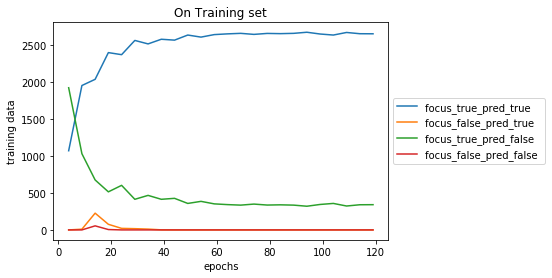

In [285]:
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.show()

In [286]:
df_test

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,4,0,1000,333,0,667,0
1,9,355,645,682,4,314,0
2,14,294,706,741,66,186,7
3,19,371,629,839,16,145,0
4,24,370,630,818,10,172,0
5,29,546,454,862,6,132,0
6,34,761,239,823,0,177,0
7,39,660,340,825,1,174,0
8,44,823,177,867,0,133,0
9,49,731,269,884,0,116,0


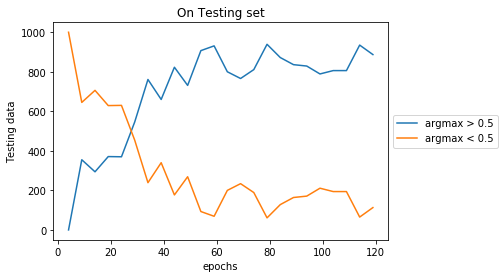

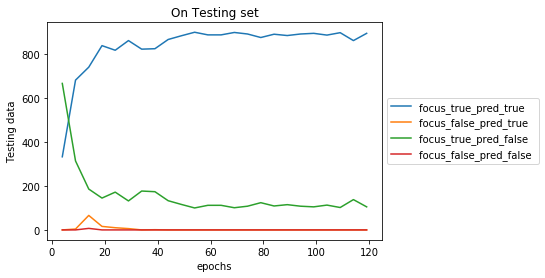

In [287]:
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.show()

In [288]:
print(x[0])

[ 0.26274649 -1.52869138]


In [289]:
for i in range(9):
    print(x[0,2*i:2*i+2])

[ 0.26274649 -1.52869138]
[]
[]
[]
[]
[]
[]
[]
[]
